## 0. Setup / 初始化（Run once）

**中文说明**
- 这一格只需要运行一次：读取 `model_df` 与 Q1 的输出文件（posterior summaries / PPC summaries）。
- 同时构造“标准周”的筛选（近似）：有节目 + 单淘汰 + 无退赛/退出事件（用于 **Consistency** 图）。
- **Certainty** 图默认使用所有有效周（有节目且选手 active），不强制要求当周必须发生淘汰。
- 后面每一张图都会直接使用这里生成的数据表。

**English**
- Run this cell once: load `model_df` and Q1 outputs (posterior summaries / PPC summaries).
- Build an approximate "standard week" filter: show exists + single elimination + no withdrawal (used for **Consistency** plots).
- **Certainty** plots use all valid weeks by default (show exists & active), not requiring an elimination that week.
- All following plot cells reuse the prepared tables.


In [19]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Load model_df ----------
try:
    df = model_df.copy()  # if you already have model_df in memory
    print("Using existing variable: model_df")
except NameError:
    df = pd.read_csv("model_df.csv")
    print("Loaded from file: model_df.csv")

required_cols = ["season","scheme","week","week_exists","active","is_eliminated_this_week","withdrew_event_week","n_active"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("[WARN] model_df is missing columns:", missing)
    print("If your column names differ, rename them in df before plotting.")

# ---------- Load posterior F summary (for certainty) ----------
F_paths = sorted(glob.glob("*posterior_F_summary*.csv"))
F_list = []
for p in F_paths:
    try:
        tmp = pd.read_csv(p)
        F_list.append(tmp)
    except Exception as e:
        print("Failed reading:", p, e)

F_all = pd.concat(F_list, ignore_index=True) if len(F_list) else None
print("F summary files found:", F_paths)

# ---------- Build F_cert (certainty over ALL valid weeks) ----------
# For certainty, we typically want uncertainty for each contestant/week even if no elimination happened.
# We restrict to valid weeks where the show exists and the contestant is active (from model_df).
if F_all is not None:
    valid_weeks = df[(df["week_exists"] == True) & (df["active"] == True)][["season","scheme","week"]].drop_duplicates()
    F_cert = F_all.merge(valid_weeks, on=["season","scheme","week"], how="inner")
else:
    F_cert = None


# ---------- Load PPC summary (for consistency) ----------
P_paths = sorted(glob.glob("*ppc*summary*.csv")) + sorted(glob.glob("*ppc*main_only*.csv"))
P_list = []
for p in P_paths:
    try:
        tmp = pd.read_csv(p)
        # some outputs may not include scheme; attempt to infer from filename
        if "scheme" not in tmp.columns:
            if "percent" in p: tmp["scheme"] = "percent"
            elif "bottom2" in p: tmp["scheme"] = "rank_bottom2"
            elif "rank" in p: tmp["scheme"] = "rank"
        P_list.append(tmp)
    except Exception as e:
        print("Failed reading:", p, e)

P_all = pd.concat(P_list, ignore_index=True) if len(P_list) else None
print("PPC files found:", P_paths)

# ---------- Build standard-week filter (robust) ----------
# NOTE: in this dataset, withdrew_event_week often stores the week number of withdrawal (not boolean).
# We build a per-row withdrew_this_week boolean: withdrew_event_week == week (or use it directly if already boolean).

if "withdrew_event_week" in df.columns:
    col = df["withdrew_event_week"]
    if col.dtype == bool:
        df["withdrew_this_week"] = col.fillna(False)
    else:
        df["withdrew_this_week"] = col.notna() & (col.round().astype("Int64") == df["week"].astype("Int64"))
else:
    df["withdrew_this_week"] = False

wk = df[df["week_exists"] == True].copy()
wk_sum = (wk[wk["active"] == True]
          .groupby(["season","scheme","week"], as_index=False)
          .agg(elim_cnt=("is_eliminated_this_week","sum"),
               withdrew_any=("withdrew_this_week","max"),
               n_active=("n_active","max")))
wk_sum["is_standard_single_elim"] = (wk_sum["elim_cnt"] == 1) & (wk_sum["withdrew_any"] == False)

std_cnt = int(wk_sum["is_standard_single_elim"].sum())
print("Standard weeks rows:", std_cnt, "/", len(wk_sum))
if std_cnt == 0:
    print("[WARN] No standard single-elim weeks found (based on current columns). Will fall back to ALL weeks for plots.")
# ---------- Merge helpers ----------

def attach_standard_flag(T):
    if T is None: 
        return None
    need = ["season","scheme","week"]
    for c in need:
        if c not in T.columns:
            raise ValueError(f"Missing column '{c}' in table. Columns are: {list(T.columns)[:30]} ...")
    return T.merge(wk_sum[["season","scheme","week","is_standard_single_elim"]], on=["season","scheme","week"], how="left")

P_std = attach_standard_flag(P_all)
if P_std is not None:
    if std_cnt > 0:
        P_std = P_std[P_std["is_standard_single_elim"] == True].copy()
    else:
        # fallback: use all weeks
        P_std = P_std.copy()

F_std = attach_standard_flag(F_all)
if F_std is not None:
    if std_cnt > 0:
        F_std = F_std[F_std["is_standard_single_elim"] == True].copy()
    else:
        # fallback: use all weeks
        F_std = F_std.copy()


print("Ready: P_std =", None if P_std is None else P_std.shape, "| F_std =", None if F_std is None else F_std.shape)


Loaded from file: model_df.csv
F summary files found: ['Q1_percent_posterior_F_summary.csv', 'Q1_posterior_F_summary.csv', 'Q1_rank_bottom2_posterior_F_summary.csv', 'Q1_rank_posterior_F_summary.csv']
PPC files found: ['Q1_percent_ppc_summary.csv', 'Q1_percent_ppc_summary_with_event.csv', 'Q1_ppc_summary.csv', 'Q1_rank_bottom2_ppc_summary.csv', 'Q1_rank_bottom2_ppc_summary_with_event.csv', 'Q1_rank_ppc_summary.csv', 'Q1_rank_ppc_summary_with_event.csv', 'Q1_percent_ppc_main_only.csv', 'Q1_rank_bottom2_ppc_main_only.csv', 'Q1_rank_ppc_main_only.csv']
Standard weeks rows: 232 / 335
Ready: P_std = (724, 13) | F_std = (2193, 10)


## Figure 1. Consistency distribution by scheme / 不同赛制一致性分布（箱线图） 必须要

**中文说明**
- 指标：`pp_mean_prob_obs`（PPC：后验生成结果与真实淘汰一致的概率均值）。
- 越接近 1 说明模型越能复现真实淘汰；越低说明该周/该赛制更难满足约束或信息不足。
- 这张图回答 Q1 的：*Does your model correctly estimate fan votes consistent with eliminations?*

**English**
- Metric: `pp_mean_prob_obs` (PPC: mean probability that simulated elimination matches the observed one).
- Closer to 1 ⇒ more consistent with observed eliminations; lower ⇒ harder weeks / weaker constraints.
- This directly answers: *Are results consistent with who was eliminated each week?*


C:\Users\qinyu\AppData\Local\Temp\ipykernel_43092\1372194299.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labs, showfliers=False)


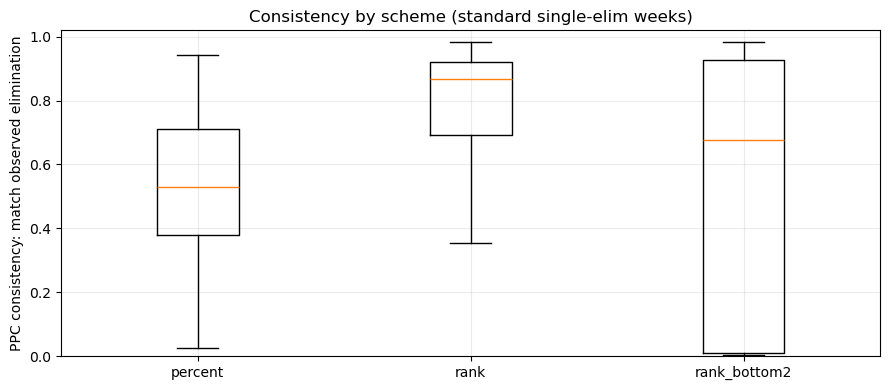

In [20]:
if P_std is None or "pp_mean_prob_obs" not in P_std.columns:
    print("[SKIP] PPC table missing or 'pp_mean_prob_obs' not found.")
else:
    schemes = sorted(P_std["scheme"].dropna().unique())
    data, labs = [], []
    for s in schemes:
        arr = P_std.loc[P_std["scheme"]==s, "pp_mean_prob_obs"].dropna().to_numpy()
        if arr.size > 0:
            data.append(arr)
            labs.append(s)

    if len(data) == 0:
        print("[SKIP] No data available for boxplot after filtering.")
    else:
        plt.figure(figsize=(9,4))
        plt.boxplot(data, labels=labs, showfliers=False)
        plt.ylim(0, 1.02)
        plt.ylabel("PPC consistency: match observed elimination")
        plt.title("Consistency by scheme (standard single-elim weeks)")
        plt.grid(alpha=0.25)
        plt.tight_layout()
        plt.show()


## Figure 1 — Consistency by scheme (standard single-elim weeks)  
## 图 1 — 不同方案的一致性分布（标准单淘汰周）

### 中文解释
**这张图在衡量什么？**  
- 纵轴是 `pp_mean_prob_obs`：来自 Posterior Predictive Check (PPC) 的指标，表示“模型在后验抽样下，生成的淘汰结果与真实淘汰一致”的平均概率。  
- 值越接近 1，说明模型越能复现真实淘汰（consistency 越高）；越接近 0，说明模型经常复现失败。

**为什么要限制在 standard single-elim weeks？**  
- 题目要求“是否与每周淘汰一致”，而“单淘汰周”规则清晰，最能公平比较不同方案；双淘汰/无淘汰/退赛等周会引入额外机制，导致一致性指标不可比。

**怎么读箱线图？**  
- 箱体中线：中位数（典型一致性）。  
- 箱体高度：周与周之间的一致性波动范围（IQR）。  
- “须”很长或接近 0：说明某些周模型会严重失配（可能是特殊周、或该方案在某些周约束不足）。

**你这张图能说明什么？（从图形直观看）**  
- `rank` 的中位数更高、更集中：通常代表它在标准周下更稳定地复现淘汰。  
- `percent` 中位数更低：说明仅靠 percent 方案时，模型更容易出现与淘汰不一致的周。  
- `rank_bottom2` 波动很大：有些周很准、有些周几乎不准，提示该机制对“周结构/噪声”更敏感。

**为什么要看这张图？**  
- 它直接回答 Q1 的第一个子问题：模型是否产生与真实淘汰一致的 fan-vote 估计？并能比较三种机制谁更可靠。

### English explanation
**What does this measure?**  
- Y-axis `pp_mean_prob_obs` is a PPC metric: the mean probability that simulated eliminations match the observed elimination under posterior draws.  
- Closer to 1 ⇒ higher consistency; closer to 0 ⇒ frequent mismatch.

**Why restrict to standard single-elimination weeks?**  
- Single-elim weeks have consistent rules, making schemes comparable. Special weeks (double/no elimination, withdrawals) introduce extra mechanisms and confound consistency.

**How to read the boxplot?**  
- Median line = typical consistency.  
- Box height (IQR) = variability across weeks.  
- Long whiskers / values near 0 = occasional severe mismatches in some weeks.

**What your plot suggests (visually)?**  
- `rank` is higher and more stable; `percent` is lower; `rank_bottom2` is highly variable, indicating sensitivity to episode structure/noise.

**Why do we look at this?**  
- It directly answers whether the estimated fan votes produce elimination results consistent with reality, and compares robustness across schemes.


## Figure 2. Consistency heatmap (season × week) / 一致性热力图（季 × 周）必须要

**中文说明**
- 横轴 week，纵轴 season，颜色是 `pp_mean_prob_obs` 的均值。
- 用来定位“模型最不一致”的周：通常是退赛/双淘汰/信息变形的周（即使你筛了标准周，也可能残留难点）。
- 报告里可以说：我们用它找 outlier weeks，并解释原因。

**English**
- X-axis week, Y-axis season; color = mean `pp_mean_prob_obs`.
- Helps locate "hard weeks" where the model is less consistent (even after standard-week filtering).
- In the report: identify outlier weeks and discuss possible reasons.


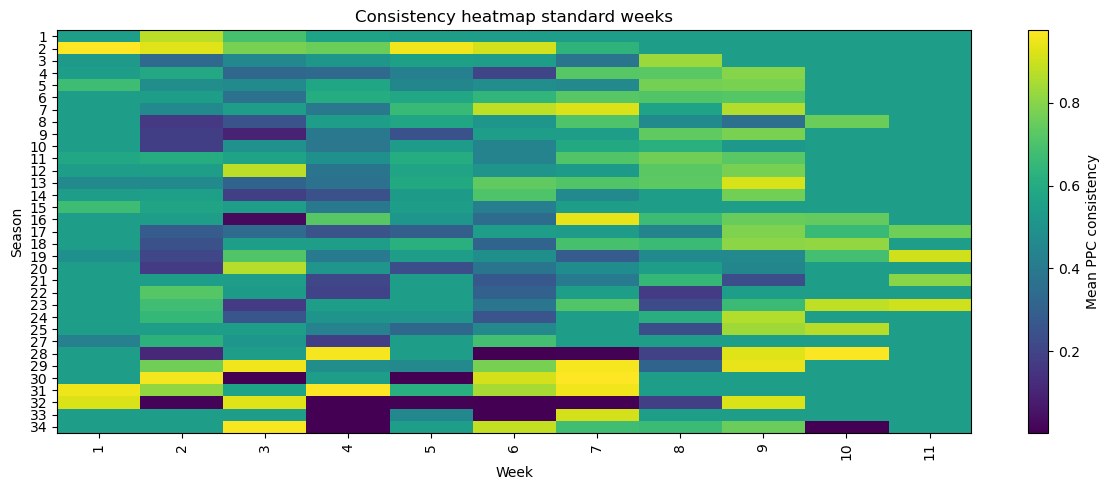

In [21]:
if P_std is None or "pp_mean_prob_obs" not in P_std.columns:
    print("[SKIP] PPC table missing or 'pp_mean_prob_obs' not found.")
else:
    heat = P_std.pivot_table(index="season", columns="week", values="pp_mean_prob_obs", aggfunc="mean")
    mat = heat.to_numpy()

    # fill NaN for visualization only (keep analysis table intact)
    fill = np.nanmean(mat) if np.isfinite(np.nanmean(mat)) else 0.0
    mat2 = np.where(np.isnan(mat), fill, mat)

    plt.figure(figsize=(12,5))
    plt.imshow(mat2, aspect="auto")
    plt.yticks(range(len(heat.index)), heat.index)
    plt.xticks(range(len(heat.columns)), heat.columns, rotation=90)
    plt.colorbar(label="Mean PPC consistency")
    plt.title("Consistency heatmap standard weeks")
    plt.xlabel("Week")
    plt.tight_layout()
    plt.ylabel("Season")
    plt.show()


## Figure 2 — Consistency heatmap (season × week), standard weeks  
## 图 2 — 一致性热力图（季 × 周），标准周

### 中文解释
**这张图在展示什么？**  
- 横轴：Week；纵轴：Season。  
- 颜色：该 season-week 的平均 `pp_mean_prob_obs`（越亮越一致，越暗越不一致）。

**怎么读？**  
- 看“暗色块”：这些是模型在特定周/特定季更难复现淘汰的地方。  
- 同一列（同一 week）如果多季偏暗：说明这一周类型可能天然更难（例如早期信息少、选手多、约束弱）。  
- 同一行（同一 season）若有局部暗块：说明该季某些周可能存在特殊事件（即使你筛了标准周，仍可能残留“接近特殊周”的效应）。

**为什么要看这张图？**  
- Boxplot 只告诉你总体分布，但看不见“哪里出问题”。热力图能定位：  
  1) 哪些 week 是“系统性难周”；  
  2) 哪些 season 有异常周（可作为讨论点：规则变化、退赛影响、数据缺失/噪声等）。

**报告里可以怎么写？**  
- “Consistency is not uniform across season-weeks; several localized low-consistency cells indicate weeks with reduced identifiability of fan-vote signals.”

### English explanation
**What is shown?**  
- X-axis: week; Y-axis: season.  
- Color: mean `pp_mean_prob_obs` per season-week (brighter = more consistent).

**How to read it?**  
- Dark cells highlight weeks where the model struggles to reproduce eliminations.  
- Dark columns suggest systematically hard week types; dark patches within a season suggest season-specific anomalies.

**Why do we look at this?**  
- The boxplot shows overall distribution but not *where* failures occur. The heatmap localizes hard/outlier weeks for interpretation and discussion.

**Report-ready phrasing**  
- “Consistency is heterogeneous across season-weeks; low-consistency pockets indicate reduced identifiability in those weeks.”



## Figure 3. Weekly consistency trend (one season) / 单季一致性周趋势

**中文说明**
- 选一季做“故事线”展示：每周 `pp_mean_prob_obs` 怎么变化。
- 常见现象：后期选手变少 → 约束更强 → 一致性上升（但也可能某些周异常下降）。
- 这张图很适合放在结果段落里做“解释型可视化”。

**English**
- Pick one season and show the week-by-week `pp_mean_prob_obs` trend.
- Typical pattern: fewer contestants later ⇒ stronger constraints ⇒ higher consistency (with exceptions).
- Great narrative plot for the Results section.


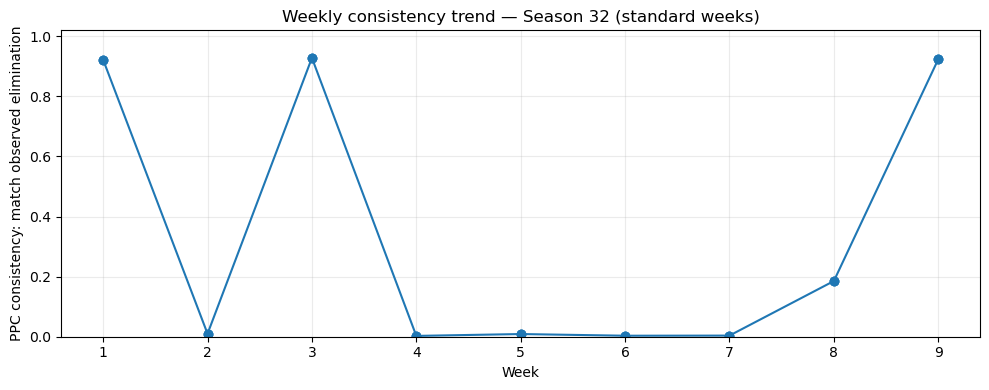

In [22]:
if P_std is None or "pp_mean_prob_obs" not in P_std.columns:
    print("[SKIP] PPC table missing or 'pp_mean_prob_obs' not found.")
else:
    # pick the season with lowest mean consistency (more interesting to explain)
    pick_season = int(P_std.groupby("season")["pp_mean_prob_obs"].mean().sort_values().index[0])
    one = P_std[P_std["season"]==pick_season].sort_values("week")

    plt.figure(figsize=(10,4))
    plt.plot(one["week"], one["pp_mean_prob_obs"], marker="o")
    plt.ylim(0, 1.02)
    plt.grid(alpha=0.25)
    plt.title(f"Weekly consistency trend — Season {pick_season} (standard weeks)")
    plt.xlabel("Week")
    plt.ylabel("PPC consistency: match observed elimination")
    plt.tight_layout()
    plt.show()


## Figure 3 — Weekly consistency trend (one season), standard weeks  作为特殊例子case来弄
## 图 3 — 单季一致性周趋势（标准周）

### 中文解释
**这张图在展示什么？**  
- 选取某一季（你这里是 Season 32），横轴是 Week，纵轴是该周的 `pp_mean_prob_obs`。  
- 它是“把热力图的一行拿出来”，用折线讲故事。

**怎么读？**  
- 点越高：该周模型越能复现淘汰。  
- 若出现接近 0 的周：表示这一周在后验模拟里几乎从不产生真实淘汰结果——通常意味着这周约束不足或存在与模型假设不一致的节目结构。

**为什么要看这张图？**  
- 题目不仅要“总体一致性”，还要你解释 consistency 是否会随周改变。  
- 折线图最适合写“过程解释”：比如“早期更不稳定/中期改善/某几周异常”。  
- 你也可以用它挑选“最值得解释的异常周”做 case study。

**写进报告的角度（很加分）**  
- 说明：consistency 并非固定不变，而是随 week 波动；并给出“最不一致的周”作为进一步分析对象（例如回看该周是否特殊、是否存在数据结构差异）。

### English explanation
**What is shown?**  
- For a chosen season (Season 32 here), x = week, y = `pp_mean_prob_obs` for that week.

**How to read it?**  
- Higher points = more consistent reproduction of eliminations.  
- Near-zero weeks indicate the model almost never reproduces the observed elimination under posterior simulation (often due to weak constraints or episode structure mismatch).

**Why do we look at this?**  
- The prompt asks whether consistency varies across weeks; this line plot provides a clear temporal narrative and helps select outlier weeks for deeper explanation.

**Report angle**  
- Emphasize week-to-week variability and highlight the lowest-consistency weeks as candidates for case study / discussion of special conditions.


## Figure 4. Certainty heatmap (celebrity × week) / 不确定性热力图（选手 × 周）

**中文说明**
- 指标：`F_CI_width = F_q975 - F_q025`（95%可信区间宽度）。
- 越大 = 越不确定（certainty 越低）；越小 = 越确定。
- 热力图能说明：certainty 不是固定值，会随“选手/周”改变 —— 这是题目明确要你回答的点。

**English**
- Metric: `F_CI_width = F_q975 - F_q025` (95% credible interval width).
- Larger width ⇒ more uncertainty (lower certainty); smaller ⇒ more certain.
- This shows certainty varies by contestant and week — explicitly required by the prompt.


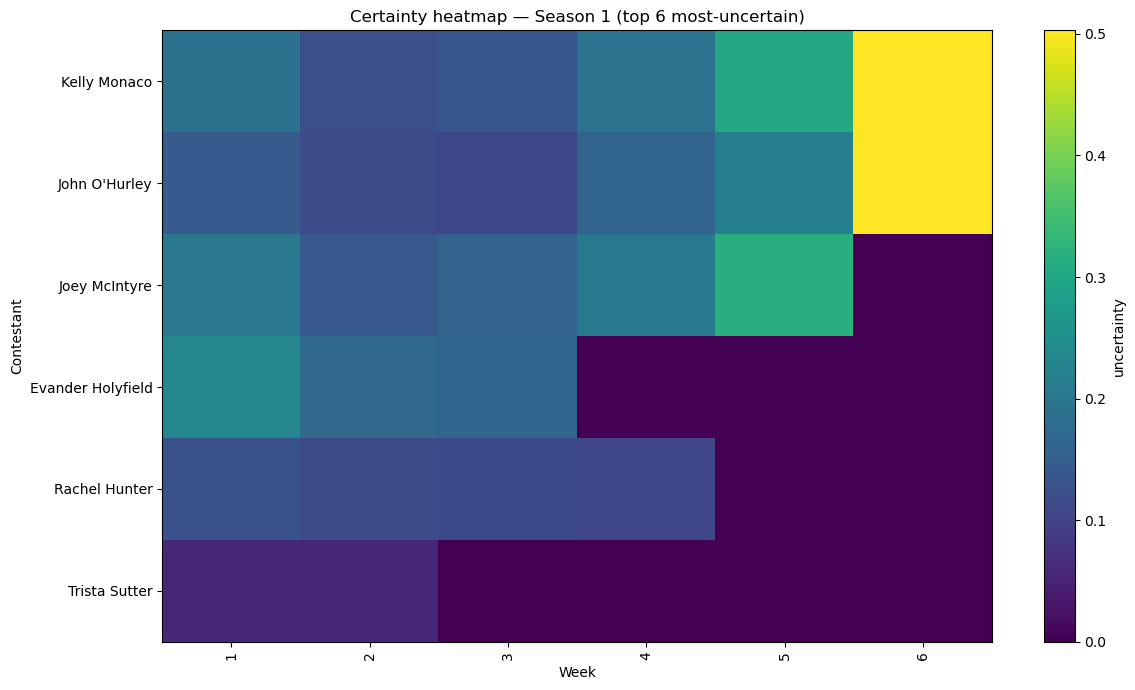

In [23]:
if F_cert is None or "F_CI_width" not in F_cert.columns:
    print("[SKIP] F summary missing or 'F_CI_width' not found.")
else:
    # pick season with largest average uncertainty (most illustrative)
    pick_season = int(F_cert.groupby("season")["F_CI_width"].mean().sort_values(ascending=False).index[0])
    Fs = F_cert[F_cert["season"]==pick_season].copy()

    heat = Fs.pivot_table(index="celebrity_name", columns="week", values="F_CI_width", aggfunc="mean")

    # show top-K most uncertain celebrities for readability
    K = 25 if heat.shape[0] > 25 else heat.shape[0]
    order = heat.mean(axis=1).sort_values(ascending=False).head(K).index
    heat2 = heat.loc[order].fillna(0).to_numpy()

    plt.figure(figsize=(12,7))
    plt.imshow(heat2, aspect="auto")
    plt.yticks(range(K), order)
    plt.xticks(range(len(heat.columns)), heat.columns, rotation=90)
    plt.colorbar(label="uncertainty")
    plt.title(f"Certainty heatmap — Season {pick_season} (top {K} most-uncertain)")
    plt.xlabel("Week")
    plt.tight_layout()
    plt.ylabel("Contestant")
    plt.show()

    # keep for later cells
    _pick_season_uncert = pick_season


## Figure 4 — Certainty heatmap (Season 1, top most-uncertain contestants)  特殊例子解释
## 图 4 — 不确定性热力图（Season 1，最不确定的选手 Top K）

### 中文解释
**这张图在衡量什么？**  
- 颜色是“不确定性”（uncertainty），通常来自 `F_CI_width = F_q975 - F_q025`（95% credible interval 的宽度）。  
- 值越大 → 后验区间越宽 → fan vote share 越不确定（certainty 越低）。  
- 值越小 → 后验区间越窄 → 更确定。

**怎么读？**  
- 横轴 Week、纵轴 Contestant。  
- 找“亮块”：说明该选手在该周的 fan-share 估计非常不稳。  
- 也可以看“整行变亮”：表示这个选手整体都很难估计；“某几周突然变亮”：表示该周信息/约束发生变化（例如打分差距变小、多人分数接近、导致淘汰边界更模糊）。

**为什么要看这张图？**  
- 题目问 certainty 是否对每个 contestant/week 都一样——这张图可以直接回答：**不一样**。  
- 它还能告诉你“不确定性集中在哪些人/哪些周”，为解释/改进模型提供方向。

### English explanation
**What does it measure?**  
- Color encodes uncertainty, typically `F_CI_width = F_q975 - F_q025` (95% credible interval width).  
- Larger width ⇒ higher posterior uncertainty (lower certainty); smaller ⇒ more certain.

**How to read it?**  
- X = week, Y = contestant.  
- Bright cells indicate weeks/contestants with highly uncertain fan-share estimates.  
- Sudden increases can reflect reduced information or tighter competition in those weeks.

**Why do we look at this?**  
- It directly shows certainty is not constant across contestants/weeks and localizes where uncertainty concentrates, supporting both interpretation and model refinement.


## Figure 5. Weekly certainty trend / Certainty 每周趋势（中位数 + 四分位带）

**中文说明**
- 用每周所有 active 选手的 `F_CI_width` 来总结不确定性趋势：
  - 中位数（median）是“典型不确定性”
  - IQR（25%-75%）是“人群差异范围”
- 趋势线回答：certainty 是否随 week 改变，以及改变的方向。

**English**
- Summarize weekly uncertainty using `F_CI_width` across active contestants:
  - median = typical uncertainty
  - IQR (25%-75%) = dispersion across contestants
- This answers whether certainty changes over weeks and how.


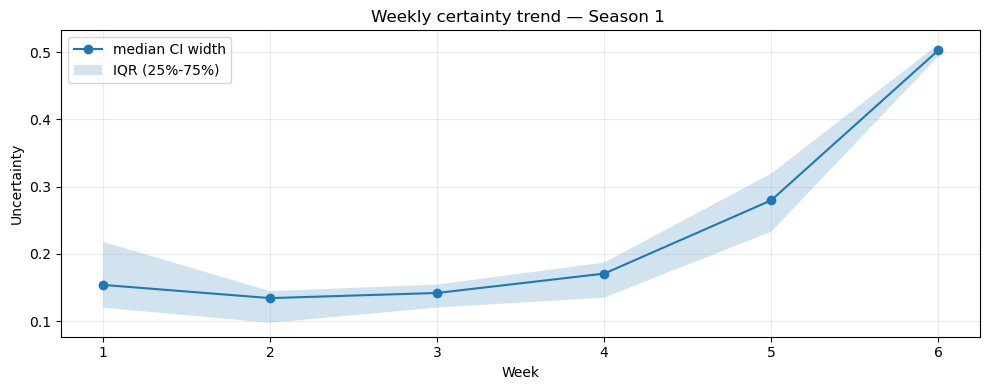

In [24]:
if F_cert is None or "F_CI_width" not in F_cert.columns:
    print("[SKIP] F summary missing or 'F_CI_width' not found.")
else:
    pick_season = globals().get("_pick_season_uncert", int(F_cert["season"].mode()[0]))
    Fs = F_cert[F_cert["season"]==pick_season].copy()

    g = (Fs.groupby("week")["F_CI_width"]
           .agg(q25=lambda x: np.nanquantile(x, 0.25),
                med=lambda x: np.nanquantile(x, 0.50),
                q75=lambda x: np.nanquantile(x, 0.75))
           .reset_index()
           .sort_values("week"))

    plt.figure(figsize=(10,4))
    plt.plot(g["week"], g["med"], marker="o", label="median CI width")
    plt.fill_between(g["week"], g["q25"], g["q75"], alpha=0.2, label="IQR (25%-75%)")
    plt.grid(alpha=0.25)
    plt.title(f"Weekly certainty trend — Season {pick_season} ")
    plt.xlabel("Week")
    plt.ylabel("Uncertainty")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Figure 5 — Weekly certainty trend (Season 1): median + IQR  ？不要也行
## 图 5 — 每周不确定性趋势（Season 1）：中位数 + 四分位带

### 中文解释
**这张图在展示什么？**  
- 横轴 Week；纵轴是“该周所有 active 选手的不确定性”的汇总：  
  - 折线：`median uncertainty`（典型不确定性）  
  - 阴影：IQR（25%-75%，表示选手之间差异）

**怎么读？**  
- 线越高：这一周整体更不确定。  
- 阴影越宽：说明不同选手之间的不确定性差异越大。  
- 若后期上升：可能因为 active 人数减少、或某些周出现极端 fan-share 分化/数据结构变化，使区间变宽。

**为什么要看这张图？**  
- 题目要求“certainty 的周趋势”，并问“是否总一样”。  
- 这张图回答两点：  
  1) certainty 随 week 变化（趋势线）；  
  2) certainty 在同一周不同人也不同（IQR 阴影）。

**写进报告的方式**  
- “Uncertainty increases toward later weeks in Season 1, and the IQR band widens, indicating both higher overall uncertainty and increased heterogeneity across contestants.”

### English explanation
**What is shown?**  
- X = week; Y summarizes uncertainty across active contestants:
  - line = weekly median uncertainty  
  - shaded band = IQR (25%-75%)

**How to read it?**  
- Higher line ⇒ greater overall uncertainty that week.  
- Wider band ⇒ more heterogeneity across contestants.

**Why do we look at this?**  
- The prompt asks for weekly certainty trends and whether certainty differs by contestant/week. This plot addresses both via the median trend and IQR dispersion.

**Report phrasing**  
- “Uncertainty varies by week and shows measurable dispersion across contestants, indicating non-uniform certainty across time and individuals.”


## Figure 6. One-contestant posterior over weeks / 单选手每周后验（均值±95%CI）

**中文说明**
- 展示某个选手在每周的 `F_mean` 以及 95% CI。
- 用来强调：同一个人也会出现“早期不确定、后期更确定”（或相反）的变化。
- 这张图非常适合放在附录或 case study 小节。

**English**
- Plot a contestant’s `F_mean` with 95% CI across weeks.
- Highlights within-contestant changes in certainty over time.
- Great for an appendix or a small case study section.


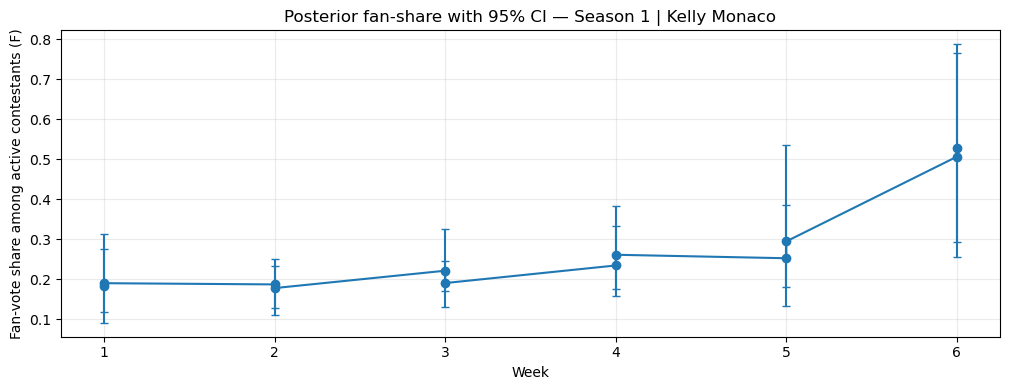

In [25]:
if F_cert is None or not set(["F_mean","F_q025","F_q975","celebrity_name"]).issubset(F_cert.columns):
    print("[SKIP] Missing required columns in F summary (need F_mean, F_q025, F_q975, celebrity_name).")
else:
    pick_season = globals().get("_pick_season_uncert", int(F_cert["season"].mode()[0]))
    Fs = F_cert[F_cert["season"]==pick_season].copy()

    # Try to pick champion-like contestant if placement exists; otherwise pick most frequent name
    if "placement" in df.columns and df[df["season"]==pick_season]["placement"].notna().any():
        champ = (df[df["season"]==pick_season].dropna(subset=["placement"])
                 .sort_values("placement")["celebrity_name"].iloc[0])
    else:
        champ = Fs["celebrity_name"].value_counts().index[0]

    one = Fs[Fs["celebrity_name"]==champ].sort_values("week")

    plt.figure(figsize=(10,4))
    plt.errorbar(one["week"], one["F_mean"],
                 yerr=[one["F_mean"]-one["F_q025"], one["F_q975"]-one["F_mean"]],
                 fmt="o-", capsize=3)
    plt.grid(alpha=0.25)
    plt.title(f"Posterior fan-share with 95% CI — Season {pick_season} | {champ}")
    plt.xlabel("Week")
    plt.tight_layout()
    plt.ylabel("Fan-vote share among active contestants (F)")
    plt.show()


## Figure 6 — Posterior fan-share with 95% CI (Season 1 | Kelly Monaco)  
## 图 6 — 单个选手的后验 fan-share（均值 + 95% CI）

### 中文解释
**这张图在展示什么？**  
- 针对单个选手（这里是 Kelly Monaco），每周的 fan-share 后验估计：  
  - 点/线：`F_mean`（后验均值）  
  - 误差棒：`[F_q025, F_q975]`（95% credible interval）

**怎么读？**  
- 均值上升：模型认为该选手相对其他 active 选手的 fan-share 在上升。  
- 误差棒变长：该周不确定性变大；变短：更确定。  
- 后期均值明显提高且区间变宽/变窄，能帮助你解释“是否受竞争人数变化、评分差距变化影响”。

**为什么要看这张图？**  
- 热力图/趋势图是“总体”，但题目也强调“是否对每个 contestant/week 都一样”。  
- 单人轨迹能非常直观地展示：同一人不同周的 certainty 会变化；并能做一个 case study 让报告更像“研究”而不是“只画图”。

### English explanation
**What is shown?**  
- For one contestant (Kelly Monaco), we plot posterior fan-share each week:
  - points/line = posterior mean `F_mean`  
  - error bars = 95% credible interval `[F_q025, F_q975]`

**How to read it?**  
- Rising mean indicates increasing relative fan-share among active contestants.  
- Longer error bars indicate higher uncertainty; shorter indicates higher certainty.

**Why do we look at this?**  
- It provides an interpretable case study showing certainty varies across weeks even for the same contestant, complementing aggregate heatmaps/trends with a concrete narrative.


## Figure 7. Uncertainty vs Consistency / 不确定性与一致性的关系 必要

**中文说明**
- 每个点是一个 season-week：
  - x：该周 `median(F_CI_width)`（不确定性）
  - y：该周 `pp_mean_prob_obs`（一致性）
- 如果出现“x 大 y 小”的区域多：说明不确定性高的时候模型也更难复现淘汰（合理）。
- 用这张图可以把 consistency 和 certainty 两部分串起来讲。

**English**
- Each point is a season-week:
  - x: weekly median uncertainty `median(F_CI_width)`
  - y: weekly consistency `pp_mean_prob_obs`
- If many points show high x and low y, uncertainty tends to accompany lower consistency.
- This links the two required components in one view.


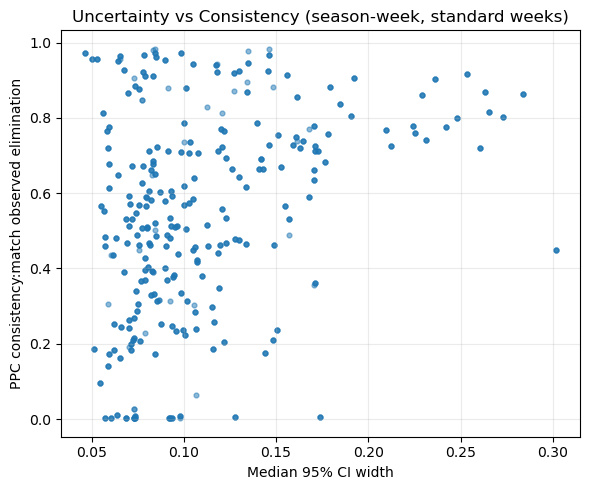

In [26]:
if (F_std is None) or (P_std is None):
    print("[SKIP] Need both F_std and P_std to plot uncertainty vs consistency.")
elif ("F_CI_width" not in F_std.columns) or ("pp_mean_prob_obs" not in P_std.columns):
    print("[SKIP] Missing columns for scatter (need F_CI_width and pp_mean_prob_obs).")
else:
    Fw = (F_std.groupby(["season","scheme","week"])["F_CI_width"]
            .median()
            .reset_index()
            .rename(columns={"F_CI_width":"med_CI_width"}))
    Pw = P_std[["season","scheme","week","pp_mean_prob_obs"]].copy()
    M = Fw.merge(Pw, on=["season","scheme","week"], how="inner")

    plt.figure(figsize=(6,5))
    plt.scatter(M["med_CI_width"], M["pp_mean_prob_obs"], s=12, alpha=0.5)
    plt.grid(alpha=0.25)
    plt.title("Uncertainty vs Consistency (season-week, standard weeks)")
    plt.xlabel("Median 95% CI width")
    plt.ylabel("PPC consistency:match observed elimination")
    plt.tight_layout()
    plt.show()


## Figure 7 — Uncertainty vs Consistency (season-week scatter), standard weeks  
## 图 7 — 不确定性 vs 一致性（season-week 散点），标准周

### 中文解释
**这张图在展示什么？**  
- 每个点代表一个 season-week。  
- 横轴：该周 `median 95% CI width`（不确定性）  
- 纵轴：该周 `pp_mean_prob_obs`（一致性）

**怎么读？**  
- 如果整体呈现“x 越大、y 越小”：说明不确定性越大时，模型越难复现淘汰（合理）。  
- 若点云很分散：说明一致性不仅由 uncertainty 决定，还受周结构因素影响（规则/约束强度/数据质量等）。  
- 关注右下角：高不确定 + 低一致性 → “最难周”；左上角：低不确定 + 高一致性 → “最稳周”。

**为什么要看这张图？**  
- 你需要把 consistency 和 certainty 两部分“讲成一个整体故事”：  
  - consistency 是结果对不对（淘汰复现）；  
  - certainty 是你对 fan vote 估计有多稳。  
- 这张图把两者联系起来，帮助你解释：什么时候“估计不稳也更容易错”，什么时候“虽然不稳但仍能对”。

### English explanation
**What is shown?**  
- Each dot is a season-week.  
- X-axis: weekly median 95% CI width (uncertainty).  
- Y-axis: `pp_mean_prob_obs` (consistency).

**How to read it?**  
- A downward trend would indicate higher uncertainty accompanies lower consistency.  
- A diffuse cloud suggests consistency depends on other structural factors beyond posterior width.  
- Bottom-right = hardest weeks; top-left = most reliable weeks.

**Why do we look at this?**  
- It links the two required deliverables (consistency and certainty) into one coherent diagnostic view, enabling a stronger narrative in the report.
